<a href="https://colab.research.google.com/github/congruent352/data-driven-odes/blob/master/Autonomous_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Data driven governing equations approximation using deep neural networks](https://www.researchgate.net/publication/333883271_Data_driven_governing_equations_approximation_using_deep_neural_networks)**


## **Contents**<a name = "contents"></a>

**[1. Main Idea](#1)**

**[2. Example 1](#ex1)**

**[3. Example 2](#ex2)**

**[4. Example 3](#ex3)**

**[5. Example 4](#ex4)**


## **[Main idea](#contents)**<a name = "1"></a>

**Problem**

> Consider a system of ordinary differential equations $$ \dot{\mathbf{x}} = f(\mathbf{x})$$ and assume that $f$ is unknown. When given time trajectory data, we want to make an approximation to the **solution**, not $f$ itself.

**Assumption**

> 1. We assume that the function $f$ is unknown.
>
> 2. The system is autonomous, meaning that $f$ does not depend on $t$ explicitly.
>
> 3. Time trajectory data is available. Uniform time lag assumption is not needed, but for the convenience of expression, we adopt uniform time lag for the time being. Later, we will see the method presented is still applicable to non-uniform time lag samples.

**Methodology**

> Consider the forward problem first, that is, assume that the right-hand-side function $f$ is available. To predict the next point, we may use numerical solvers for example Forward Euler Method or Runge-Kutta Method. Let's think of the Forward Euler Method. With the current state $ \mathbf{x}(t_{\text{now}}$, we can write the next state (or prediction) $\mathbf{x}(t_{\text{next}})$ as follow
$$\mathbf{x}(t_{\text{next}}) = \mathbf{x}(t_{\text{now}}) + \Delta t f(\mathbf{x}(t_{\text{now}})). \tag{1}$$
Here, $\Delta t = t_{\text{next}} - t_{\text{now}}$ is the time lag.

> Now, let's get back to the inverse problem. In terms of machine learning problem, the right-hand-side of the equation (1) is the function to be learned, especially when the input is $\mathbf{x}(t_{\text{now}})$. Then we only need to approximate $\Delta t f(\mathbf{x}(t_{\text{now}}))$ part. As a result, we will use neural network $\mathcal{N}$ and approximate the next state in the following way:
\begin{align*}
\mathbf{x}(t_{\text{next}}) & = \mathbf{x}(t_{\text{now}}) + \Delta t f(\mathbf{x}(t_{\text{now}}))
\\ & \approx \mathbf{x}(t_{\text{now}}) + \mathcal{N}(\mathbf{x}(t_{\text{now}})) \tag{2}
\end{align*}
>
> The structure of the rhs of equation (2) is **Residual Network**. So building the ResNet to make a prediction, we can compare the output with the true state and thus $L^2$ loss can be computed. The details for training will be given in the examples.

Remark

The paper contains other structures called **Recurrent ResNet** and **Recursive ResNet**. They are the variants of the ResNet structure, so here I just omit them. For details, refer the [paper](https://www.researchgate.net/publication/333883271_Data_driven_governing_equations_approximation_using_deep_neural_networks)

**Advantage**

> There are many different methods regarding inverse ode problems including **SINDy** and **PINN**,
>
> **SINDy** requires the information of gradient which can be expensive in practice. When noise considered, the gradient data has significant error, especially SINDy employs the finite difference scheme for the gradient. This idea of using residual network can avoid using gradient information, hence lowering the cost and can be more robust to noisy data.
>
> **PINN** requires strong prior knowledge to the form of equations. In the original paper, the equations were assumed to be known except for just few parameters. However, this paper makes only one assumption, that is, the system has to be autonomous. Without the explicit dependency on $t$, no further conditions on the number of parameters or the form of equations is required.
>
> In sum, this method is parsimonious and applicable to general cases without strong prior knowledge.

---

### **Training**

In practice, when a long trajectory is given, we slice the trajectory into short trajectories with length two. For example, if we have $\{x(t_i)\}_{i=1}^{n}$, then we collect $$ \{(x(t_i), x(t_{i+1}))\}_{i=1}^{n-1}$$
where the first component is an input and the second component is an output. Likewise, in the experiment we will randomly sample the initial points and then using the numerical scheme we will collect the corresponding labels.

## **[Example 1](#contents)**<a name = "ex1"></a>

$$\Large \begin{cases} \dot{x}_1 & = x_1 + x_2 - 2 \\ \dot{x_2} & = x_1 - x_2 \end{cases}$$




> **Computational Domain:** $D = [0,2]^2$
>
> **Time lag:** $\Delta = 0.1$
>
> **Mini-batch of size 10** and **shuffle after every epoch**
>
> **ResNet Structure:** 2 - 30 - 30 - 30 - 2, activated by $\tanh$
>
> **The number of samples:** Roughly mentioned. 5~10 times of the number of paraeters (about 2,000). So I sampled 10,000 points.
>
> **Optimizer:** Not mentioned, so I just used **ADAM** optimizer

### **Sample the training data from the dynamics**

At first, I will sample the training data from the ground true dynamics.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from scipy import integrate
import copy
import time
import torch
import torch.nn as nn


torch.manual_seed(1234)
np.random.seed(1234)

# The number of training data

nb = 10000

# Time lag. (It doesn't need to be uniform. Example 2 has non-uniform time lag)

dt = 0.1

# Noise level (%)

noise = 5

def sol(t, y, dt):
    
    # response function
    def func(t,y):
        a = y[0] + y[1] -2
        b = y[0] - y[1] 
        return np.array([a,b])
    
    a = sp.integrate.solve_ivp(func, t_span = (t, t+ dt), y0 = y, method = 'RK45', t_eval = np.linspace(t, t + dt, 2))
    return a.y[:,1]


# Initial point, computational domain is [0,2]^2.
x = 2*np.random.random(nb).reshape((-1,1))
y = 2*np.random.random(nb).reshape((-1,1))

x0 = np.concatenate([x,y], axis = 1)
x1 = np.zeros_like(x0)
for i in range(nb):
    z = x0[i, :]
    x1[i,:] = sol(0, z, dt)
    
def get_noisy(x, noise_level, method = 'mini-max'):
    if method == 'mini-max':
        a = np.max(x, axis = 0) - np.min(x, axis = 0)
        a = a * np.random.normal(0, noise_level / 100, size = x.shape)
    elif method == 'random':
        a = np.random.normal(0, 1, size = x.shape)
    return a + x

noisy_x0 = torch.Tensor(get_noisy(x0, noise))
noisy_x1 = torch.Tensor(get_noisy(x1, noise))
x0 = torch.Tensor(x0) # Initial points
x1 = torch.Tensor(x1) # End points

### **Define the model**

The resnet block structure is 2 - Tanh - 30 - Tanh - 30 - Tanh - 30 - Tanh - 2, so I used [2, 30, 30, 30, 2] for the layer and Tanh for the activation.

In [ ]:
from models import resnet, prediction

layers = [2, 30, 30, 30, 2]
activation = nn.Tanh()
N = resnet(layers, activation)

def loss(x,y):
    hypothesis = N(x)
    mse = torch.mean((hypothesis - y)**2)
    return mse

epochs = 1000
history = []
learning_rate = 5e-2

# Optimize
optimizer = torch.optim.Adam(N.parameters(), lr = learning_rate)


# Run the optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x0, x1)
    l.backward()
    return l


t1 = time.time()
for i in range(epochs):
    optimizer.step(closure)
    if i%100 == 0:
        with torch.no_grad():
            print('Epoch = {0} / {1}, Loss = {2}'.format(i,epochs,loss(x0, x1).numpy()))
    with torch.no_grad():
        history.append(loss(x0,x1).numpy())
t2 = time.time()
print(t2 - t1)

Epoch = 0 / 1000, Loss = 4.462375164031982
Epoch = 100 / 1000, Loss = 0.0033875247463583946
Epoch = 200 / 1000, Loss = 0.0018222254002466798
Epoch = 300 / 1000, Loss = 0.0016861549811437726
Epoch = 400 / 1000, Loss = 0.0012351562036201358
Epoch = 500 / 1000, Loss = 0.009605282917618752
Epoch = 600 / 1000, Loss = 0.0009533994598314166
Epoch = 700 / 1000, Loss = 0.000787219381891191
Epoch = 800 / 1000, Loss = 0.0021804622374475002
Epoch = 900 / 1000, Loss = 0.0007896219030953944
30.440919637680054


### **Training History**

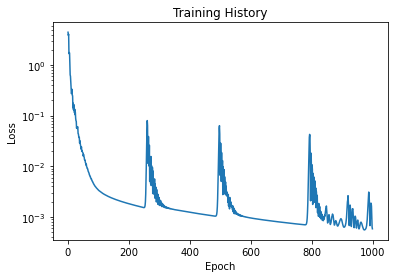

In [ ]:
plt.semilogy(history)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training History')
plt.show()

### **Prediction**

We use time-marching to test the performance of the model. That is, for given $x_0 = (1.5, 0)$, we predict $x_1$ and based on the prediction $x_1$, we apply the model again to obtain the next prediction $x_2$. Likewise, we will generate the point from $t=0$ to $t=2$ with same time lag $\Delta = 0.1$.

In [ ]:
class prediction_():
    def prediction_(net, x0, dt, nb):
        '''
        net: model / x0: initial point / dt: time-lag / nb: number of samples needed
        '''
        if type(x0) == list:
            shape = len(x0)
        else:
            shape = x0.shape[0]
        pred = np.zeros((nb+1, shape))
        pred[0,:] = x0
        for i in range(nb):
            next_point = net(torch.Tensor(pred[i,:]), dt)
            pred[i+1,:] = next_point.detach().numpy()
            del next_point
        return pred

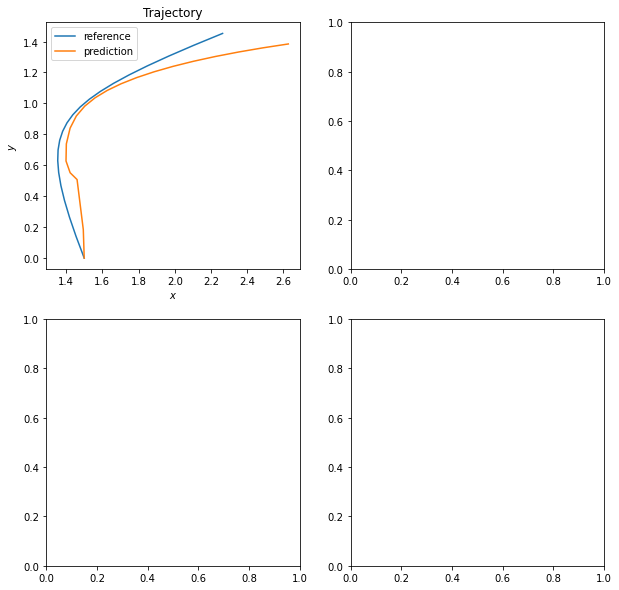

In [ ]:
# Still revising

initial_point = [1.5, 0]
dt = 0.1
nb = 20


# Generating the Reference Trajectory

reference = np.zeros((nb+1, 2))
reference[0, :] = initial_point
t = [0]
for i in range(nb):
    z = reference[i,:]
    reference[i+1, :] = sol(0, z, dt)
    t.append(t[-1] + dt)
    
    
a = prediction_.prediction_(N, initial_point, dt, nb)

f, axes = plt.subplots(2, 2, figsize = (10, 10))
axes[0,0].plot(reference[:,0], reference[:,1], label = 'reference')
axes[0,0].plot(a[:,0], a[:,1], label = 'prediction')
axes[0,0].set_xlabel('$x$')
axes[0,0].set_ylabel('$y$')
axes[0,0].set_title('Phase plot')
axes[0,0].legend()

axes[0,1].plot(t, reference[:,0], label = 'reference $x_1$')
axes[0,1].plot(t, reference[:,1], label = 'reference $x_2$')
axes[0,1].plot(t, a[:,0], label = 'prediction $x_1$')
axes[0,1].plot(t, a[:,1], label = 'prediction $x_2$')
axes[0,1].set_xlabel('$t$')
axes[0,1].set_ylabel('$x_1, x_2$')
axes[0,1].set_title('Time-trajectory')
axes[0,1].legend()

axes[1,0].semilogy(history)
axes[1,0].plot(a[:,0], a[:,1], label = 'prediction')
axes[1,0].set_xlabel('$x$')
axes[1,0].set_ylabel('$y$')
axes[1,0].set_title('Phase plot')
axes[1,0].legend()

axes[1,1].plot(reference[:,0], reference[:,1], label = 'reference')
axes[1,1].plot(a[:,0], a[:,1], label = 'prediction')
axes[1,1].set_xlabel('$x$')
axes[1,1].set_ylabel('$y$')
axes[1,1].set_title('Phase plot')
axes[1,1].legend()
f.suptitle('')
plt.show()

In [ ]:
reference.shape

(21, 2)